In [4]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import os
import sys

In [5]:
# func to initialize mean and variance images
def initBackground(initImage):
    img_arr = mpimg.imread(initImage)
    mean = img_arr
    variance = 9*np.ones(img_arr.shape)
    return (mean, variance)

In [19]:
# Reading the image 
img = cv2.imread("fruits.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

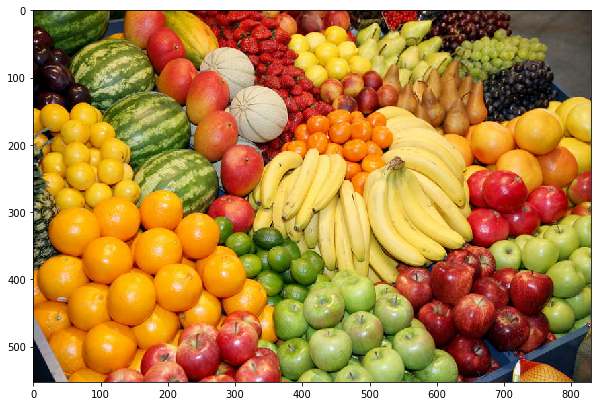

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(img)

In [6]:
# classify images into foreground and background pixels using chebyshev inequality
def ForegroundDetection(img_file, mean, variance, lmda):
    img = cv2.imread(img_file)
    d = img-mean
    y = variance*(lmda**2)
    d_2 = np.square(d)
    I = d_2-y
    
    mask = np.all(I>0, axis = 2)
    rI = 255*mask.astype(int)
    rI = rI.astype(np.uint8)
    return (rI)

In [4]:
# reduce the image noise using voting scheme
def voting(rI, eta, m, n):
    r, c = rI.shape
    cI = np.zeros((rI.shape[0], rI.shape[1]))
    
    for i in range(m, r-1-m):
        for j in range(n, c-1-n):
            img_patch = rI[i-m:i, j-n:j]
            y_unq, counts = np.unique(img_patch, return_counts = True)
            if len(coubts) == 1 & y_unq[0] == 1:
                cI[i, j] = 255
            if len(counts)>1:
                if counts[1]>eta*m*n:
                    cI[i, j] = 255
    cI = cI.astype(np.uint8)
    return cI

In [5]:
# update mean and variance images using weighted average scheme
def MeanVarUpdate(cI, img_path, M, V, alpha):
    img = mpimg.imread(img_path)
    mean_upd = np.zeros(img.shape)
    var_upd = np.zeros(img.shape)
    d = img-M
    d_2 = np.square(d)
    
    for i in range(cI.shape[0]):
        for j in range(cI.shape[1]):
            if cI[i, j] == 0:
                mean_upd[i, j, :] = (1-alpha)*M[i, j, :]+ alpha*img[i, j, :]
                var_upd[i, j, :] = (1-alpha)*(V[i, j, :] + alpha*d_2[i, j, :])
                var_upd[i, j, :] = np.clip(var_upd[i, j, :], a_min = 9, a_max = None)
    return (mean_upd, var_upd)

In [7]:
def Background_substraction(img_dir, lmda, eta, m, n, alpha):
    img_file_name = os.listdir(img_dir)
    initImage = os.path.join(img_dir, img_file_name[0])
    mean, variance = initBackground(initImage)
    
    for i in range(1, 19):
        img_path = os.path.join(img_dir, img_file_name[i])
        fig, ax = plt.subplots(1, 3, figsize=(10,10))
        
        rI = ForegroundDetection(img_path, mean, variance, lmda)
        ax[0].imshow(rI, cmap = "gray")
        
        cI = voting(rI, eta, m, n)
        mean, variance = MeanVarUpdate(cI, img_path, mean, variance, alpha)
        ax[1].imshow(cI, cmap = "gray")
        
        img = cv2.imread(img_path)
        ax[2].imshow(img, cmap = "gray")
        
        plt.show()
    return (mean, variance)

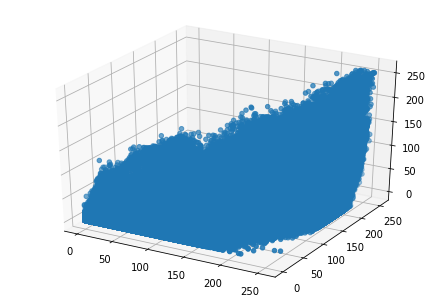

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
img = cv2.imread("fruits.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
r, g, b = cv2.split(img)
r = r.flatten()
g = g.flatten()
b = b.flatten()#plotting 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(r, g, b)
plt.show()

In [12]:
vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)

In [13]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [14]:
K = 7
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

In [15]:
center = np.uint8(center)

In [16]:
res = center[label.flatten()]
result_image = res.reshape((img.shape))

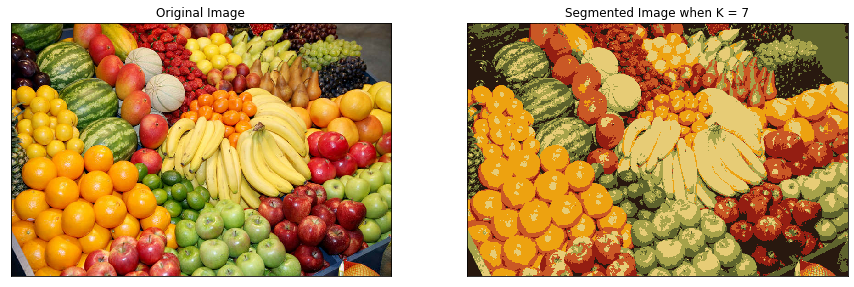

In [17]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()